In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import keras.backend as K
import plotly.express as px
from sklearn.metrics import classification_report
from tensorflow.keras.applications import xception, inception_resnet_v2
from matplotlib import pyplot as plt
import cv2 as cv
import tensorflow.keras.preprocessing.image as Image
from tensorflow.keras.models import Model
%matplotlib inline

Using TensorFlow backend.


In [2]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [43]:
# Reading data
files = tf.io.gfile.glob(r"D:/Desktop/Practicum/Covid recognition/Data/COVID 19/*")
files.extend(tf.io.gfile.glob(r"D:/Desktop/Practicum/Covid recognition/Data/NORMAL/*"))
files.extend(tf.io.gfile.glob(r"D:/Desktop/Practicum/Covid recognition/Data/Viral Pneumonia/*"))

# obtaining split sets
train_files, test_files = train_test_split(files, test_size=0.1, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

# converting to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)

TRAIN_SIZE = tf.data.experimental.cardinality(train_dataset).numpy()
VAL_SIZE = tf.data.experimental.cardinality(val_dataset).numpy()
TEST_SIZE = tf.data.experimental.cardinality(test_dataset).numpy()

In [44]:
'''
takes a file path as input
returns the target value for the given image
'''
def get_targets(file):
    split = tf.strings.split(file, os.path.sep)
    if split[-2] == 'COVID 19':
        return 0
    elif split[-2] == 'Viral Pneumonia':
        return 2
    else: return 1
    
'''
input: file path of image
returns a processed image along with the target
'''
def preprocess_img(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    
    return img, target

'''
input: image dataset
returns: shuffled, batched and prefetched set of images
return type: PrefetchDataset
'''
def preprocessing(dataset, buffer_size=650):
    dataset = dataset.shuffle(buffer_size=buffer_size).repeat()
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

def preprocess_img_xception(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = xception.preprocess_input(img)
    
    return img, target

def preprocess_img_inception(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = inception_resnet_v2.preprocess_input(img)
    
    return img, target

In [45]:
# preprocessing datasets
train_data = train_dataset.map(preprocess_img_inception)
val_data = val_dataset.map(preprocess_img_inception)
test_data = test_dataset.map(preprocess_img_inception)
test_data_x = test_dataset.map(preprocess_img)

# batching test set
test_set = test_data.batch(BATCH_SIZE)
test_set_x = test_data_x.batch(BATCH_SIZE)

train_set = preprocessing(train_data)
val_set = preprocessing(val_data)

In [46]:
# loading the inception_resnet model
model = tf.keras.models.load_model(r"D:\Desktop\Practicum\Covid recognition\output\models\covid_model_inception_resnet.h5")

In [7]:
# loading the Xception model
model_x = tf.keras.models.load_model(r"D:\Desktop\Practicum\Covid recognition\output\models\covid_model_deep.h5")

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization_5[0][0]      
______________________________________________________________________________________________

batch_normalization_198 (BatchN (None, None, None, 2 672         conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_193 (Activation)     (None, None, None, 2 0           batch_normalization_198[0][0]    
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, None, None, 1 399360      block8_7_ac[0][0]                
__________________________________________________________________________________________________
conv2d_195 (Conv2D)             (None, None, None, 2 172032      activation_193[0][0]             
__________________________________________________________________________________________________
batch_normalization_196 (BatchN (None, None, None, 1 576         conv2d_192[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [51]:
def unbatch_data(test_set, unbatch_features=False):
    '''
    returns the unbatched versions of the features and targets
    '''
    test_x = test_set.take(5000).map(lambda X,y: X)
    test_y = test_set.take(5000).map(lambda X,y: y)
    if unbatch_features:
        test_x = tf.data.Dataset.unbatch(test_x)
    test_y = tf.data.Dataset.unbatch(test_y)
    return (test_x, test_y)

In [48]:
def get_predictions(test_x, model):
    '''
    returns the predictions as class indices and as a list
    '''
    pred = model.predict(test_x)
    pred_class = np.argmax(pred, axis=1)
    pred_class = pred_class.tolist()
    return pred_class

In [55]:
def get_true_targets(test_y):
    '''
    -test_y must be unbatched
    -returns the ground truth target values as a list
    '''
    y_true = []
    for i in test_y.take(5000):
        y_true.append(i.numpy())
    return y_true

In [57]:
def get_misclassifications(y_true, y_pred):
    '''
    returns the misclassified instances as a list of tuples with the tuples like 
    (index, true class, predicted class)
    '''
    ind = 0
    misclass = []
    for i,j in zip(y_true, pred_class):
        if i != j:
            misclass.append((ind,i,j))
        ind += 1
    return misclass

##### Error analysis for Xception

In [72]:
# unbatch test data
test_x_xception, test_y_xception = unbatch_data(test_set_x)

In [61]:
model_x.evaluate(test_set_x)

13/13 [==============================] - 5s 360ms/step - loss: 0.0332 - accuracy: 0.9949


[0.03322984857200376, 0.9948586]

In [73]:
# obtaining predictions
pred_class = get_predictions(test_x_xception, model_x)

In [74]:
# misclassifications
misclass = get_misclassifications(y_true, pred_class)

In [75]:
misclass

[(52, 2, 1), (332, 2, 1)]

##### Error analysis for inception_resnet

In [76]:
# unbatch test data
test_x_inc, test_y_inc = unbatch_data(test_set)

In [77]:
# obtaining predictions
pred_class = get_predictions(test_x_inc, model)

In [78]:
len(pred_class)

389

In [91]:
# obtaining ground truth targets
y_true = get_true_targets(test_y_inc)

In [80]:
# misclassifications
misclass = get_misclassifications(y_true, pred_class)

In [81]:
misclass

[(52, 2, 1),
 (64, 1, 2),
 (221, 1, 2),
 (233, 1, 2),
 (263, 2, 0),
 (332, 2, 1),
 (368, 2, 1)]

### GradCam Analysis: On Inception-ResNet

In [23]:
# all layers
layer_names_full = [layer.name for layer in model.layers]
layer_names_full

['input_2',
 'conv2d_1',
 'batch_normalization_5',
 'activation',
 'conv2d_2',
 'batch_normalization_6',
 'activation_1',
 'conv2d_3',
 'batch_normalization_7',
 'activation_2',
 'max_pooling2d_4',
 'conv2d_4',
 'batch_normalization_8',
 'activation_3',
 'conv2d_5',
 'batch_normalization_9',
 'activation_4',
 'max_pooling2d_5',
 'conv2d_9',
 'batch_normalization_13',
 'activation_8',
 'conv2d_7',
 'conv2d_10',
 'batch_normalization_11',
 'batch_normalization_14',
 'activation_6',
 'activation_9',
 'average_pooling2d',
 'conv2d_6',
 'conv2d_8',
 'conv2d_11',
 'conv2d_12',
 'batch_normalization_10',
 'batch_normalization_12',
 'batch_normalization_15',
 'batch_normalization_16',
 'activation_5',
 'activation_7',
 'activation_10',
 'activation_11',
 'mixed_5b',
 'conv2d_16',
 'batch_normalization_20',
 'activation_15',
 'conv2d_14',
 'conv2d_17',
 'batch_normalization_18',
 'batch_normalization_21',
 'activation_13',
 'activation_16',
 'conv2d_13',
 'conv2d_15',
 'conv2d_18',
 'batch_norm

In [24]:
# getting a subset of layers for analysis - Conv_7b is the final Conv layer
layer_names = [i for i in layer_names_full if i.startswith('conv2d')]
layer_names = [layer_names[i] for i in range(0,len(layer_names),22)] + ['conv_7b']
layer_names

['conv2d_1',
 'conv2d_21',
 'conv2d_47',
 'conv2d_70',
 'conv2d_90',
 'conv2d_109',
 'conv2d_134',
 'conv2d_153',
 'conv2d_178',
 'conv2d_199',
 'conv_7b']

In [25]:
model.evaluate(test_set)

13/13 [==============================] - 8s 616ms/step - loss: 0.0704 - accuracy: 0.9820


[0.07036125252954242, 0.9820051]

In [82]:
# unbatch test data
test_x, test_y = unbatch_data(test_set)

In [84]:
def single_image_batched(image_list, image_index):
    '''
    image_index must not exceed max index of image_list
    returns batched form of single image
    '''
    sample_image = image_list[image_index]
    sample_image.shape = (1,sample_image.shape[0], sample_image.shape[1], sample_image.shape[2])
    sample_label = np.array([2])
    sample_label.shape = (1,)
    ds = tf.data.Dataset.from_tensor_slices((sample_image, sample_label)).batch(BATCH_SIZE)
    return ds

In [85]:
# 2 batches, 64 images
sample_test_batch = test_x.take(2)
sample_images = tf.data.Dataset.unbatch(sample_test_batch)
sample_images = sample_images.take(64)

# numpy format of sample images
temp = [i.numpy() for i in sample_images.take(64)]
# 43rd test image
ds = single_image_batched(temp, 43)

In [86]:
pred = model.predict(ds)

In [87]:
pred[0]

array([6.928282e-11, 4.713577e-12, 1.000000e+00], dtype=float32)

In [88]:
np.argmax(pred[0])

2

In [92]:
for i, j in enumerate(y_true):
    print(i,j)

0 1
1 2
2 2
3 2
4 1
5 1
6 0
7 0
8 1
9 0
10 1
11 1
12 1
13 0
14 0
15 0
16 1
17 1
18 1
19 1
20 0
21 0
22 0
23 1
24 1
25 0
26 2
27 2
28 2
29 0
30 0
31 0
32 1
33 2
34 1
35 2
36 0
37 2
38 2
39 1
40 1
41 0
42 2
43 2
44 0
45 0
46 0
47 1
48 0
49 1
50 1
51 0
52 2
53 1
54 1
55 0
56 2
57 0
58 2
59 1
60 2
61 1
62 0
63 0
64 1
65 1
66 2
67 1
68 0
69 0
70 1
71 1
72 1
73 2
74 0
75 0
76 1
77 0
78 1
79 2
80 1
81 2
82 2
83 0
84 2
85 0
86 2
87 1
88 2
89 1
90 1
91 2
92 1
93 0
94 2
95 2
96 2
97 2
98 2
99 1
100 1
101 1
102 0
103 1
104 1
105 1
106 2
107 1
108 2
109 2
110 1
111 0
112 0
113 0
114 0
115 1
116 0
117 0
118 1
119 0
120 2
121 1
122 2
123 1
124 1
125 0
126 1
127 1
128 2
129 2
130 2
131 2
132 0
133 1
134 0
135 2
136 2
137 2
138 1
139 1
140 2
141 0
142 2
143 2
144 2
145 0
146 2
147 1
148 1
149 0
150 0
151 0
152 1
153 1
154 1
155 2
156 1
157 0
158 0
159 2
160 1
161 0
162 0
163 1
164 0
165 1
166 0
167 0
168 2
169 2
170 0
171 1
172 2
173 1
174 2
175 2
176 2
177 1
178 2
179 1
180 0
181 2
182 1
183 2
184 0


In [106]:
# This is the entry in the prediction vector - index 2 for Pneumonia class (change this if another class)
pred_vector_out = model.output[:, 2]
heatmap = []

for layer in layer_names[-1:]:
    # The is the output feature map of the given layer
    curr_layer = model.get_layer(layer)
    
    # This is the gradient of the predicted class with regard to
    # the output feature map of selected block
    gradients = K.gradients(pred_vector_out, curr_layer.output)[0]
    
    # vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_gradients = K.mean(gradients, axis=(0,1,2))
    
    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function([model.input], [pooled_gradients, curr_layer.output[0]])
    
    # calling the function above on a sample image
    pooled_gradients_val, layer_out_value = iterate([sample_image])
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the class concerned
    for i in range(model.get_layer(layer).output_shape[-1]):
        layer_out_value[:,:,i] *= pooled_gradients_val[i]
        
    heatmap.append(np.mean(layer_out_value, axis=-1))

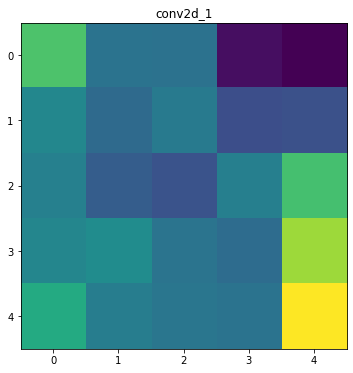

In [108]:
# normalize heatmap between 0 and 1
for i in range(len(layer_names[-1:])):
    img_heatmap = np.maximum(heatmap[i], 0)
    img_heatmap /= np.max(img_heatmap)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_heatmap)
    plt.title(layer_names[i])
    plt.show()

#### Obtaining the raw (unprocessed by deep model's preprocessing func) test images

In [109]:
test_data_2 = test_dataset.map(preprocess_img)
arr = []
for i,j in test_data_2.take(64):
    arr.append(i)

In [110]:
# 43rd raw test image
test_raw_img = arr[43]

In [111]:
test_raw_img = Image.img_to_array(test_raw_img)

In [112]:
for i, m in enumerate(heatmap):
    img_heatmap = np.maximum(m,0)
    img_heatmap /= np.max(img_heatmap)
    img_hm = cv.resize(img_heatmap, (test_raw_img.shape[0], test_raw_img.shape[1]))
    img_hm = np.uint8(255 * img_hm)
    img_hm = cv.applyColorMap(img_hm, cv.COLORMAP_JET)
    cv.imwrite(r'D:\Desktop\Practicum\Covid recognition\output\covid_{}.jpg'.format(layer_names[-1]), img_hm)

Text(0.5, 1.0, 'conv_7b')

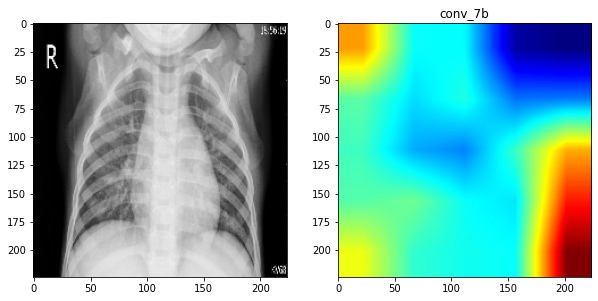

In [113]:
layer_name = 'conv_7b'
img = Image.img_to_array(
    Image.load_img(r'D:\Desktop\Practicum\Covid recognition\output\covid_{}.jpg'.format(layer_name))) / 255.
f, axarr = plt.subplots(1,2, figsize=(10,6))
axarr[0].imshow(test_raw_img)
axarr[1].imshow(img)
plt.title(layer_name)

### Intermediate feature maps

In [39]:
img_tensor = np.expand_dims(test_raw_img, axis=0)

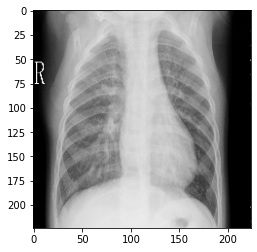

In [40]:
plt.imshow(img_tensor[0])

In [46]:
layer_subset_indices = [layer_names_full.index(i) for i in layer_names]

In [47]:
layer_subset_indices

[1, 73, 155, 239, 323, 409, 499, 585, 669, 753, 777]

In [48]:
layer_subset_objects = [model.layers[i] for i in layer_subset_indices]

In [50]:
layer_outputs = [layer.output for layer in layer_subset_objects]

In [56]:
activations_model = Model(inputs=model.input, outputs=layer_outputs)

In [77]:
layer_names

['conv2d_1',
 'conv2d_21',
 'conv2d_47',
 'conv2d_70',
 'conv2d_90',
 'conv2d_109',
 'conv2d_134',
 'conv2d_153',
 'conv2d_178',
 'conv2d_199',
 'conv_7b']

In [57]:
activations = activations_model.predict(ds)

In [68]:
first_layer_activation = activations[0]

In [69]:
first_layer_activation.shape

(1, 111, 111, 32)

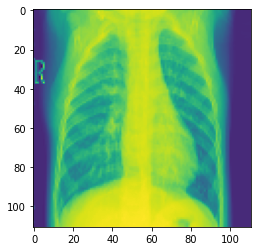

In [76]:
plt.imshow(first_layer_activation[0,:,:,3])
plt.show()

Text(0.5, 1.0, 'conv2d_1')

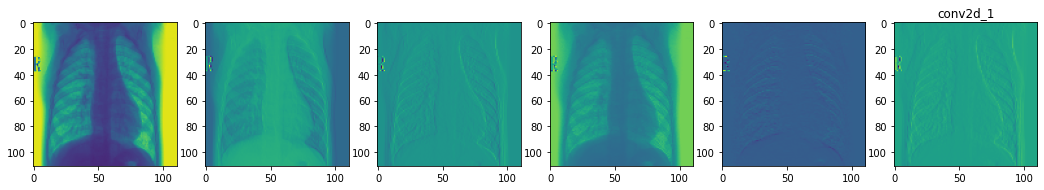

In [82]:
name = layer_names[0]
ind = [i for i in range(0, first_layer_activation.shape[-1], 6)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(first_layer_activation[0,:,:,i])
    j += 1
# fig.suptitle(name)
plt.title(name)

In [83]:
layer_21_activation = activations[1]
layer_21_activation.shape

(1, 25, 25, 32)

Text(0.5, 1.0, 'conv2d_21')

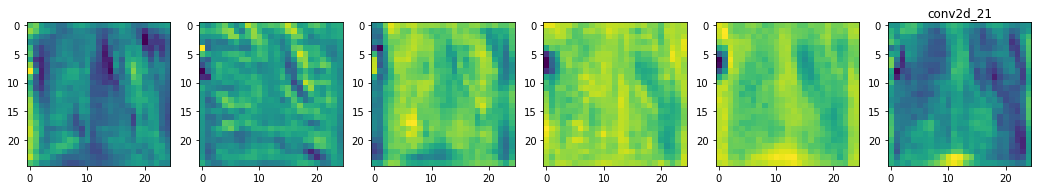

In [84]:
name = layer_names[1]
ind = [i for i in range(0, layer_21_activation.shape[-1], 6)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(layer_21_activation[0,:,:,i])
    j += 1
plt.title(name)

In [85]:
layer_47_activation = activations[2]
layer_47_activation.shape

(1, 25, 25, 48)

Text(0.5, 1.0, 'conv2d_47')

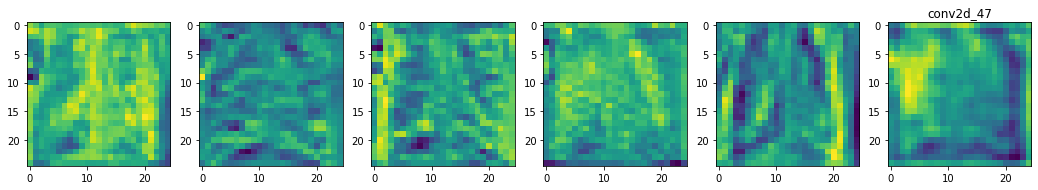

In [86]:
name = layer_names[2]
ind = [i for i in range(0, layer_47_activation.shape[-1], 8)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(layer_47_activation[0,:,:,i])
    j += 1
plt.title(name)

In [87]:
layer_70_activation = activations[3]
layer_70_activation.shape

(1, 25, 25, 32)

Text(0.5, 1.0, 'conv2d_70')

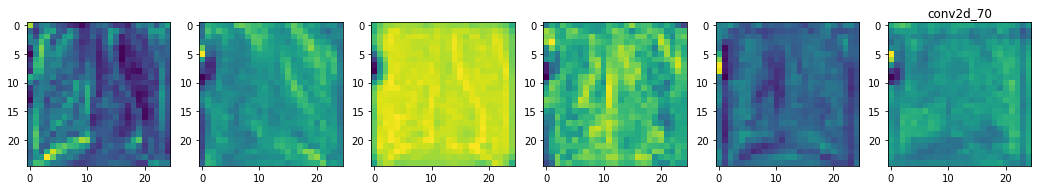

In [88]:
name = layer_names[3]
ind = [i for i in range(0, layer_70_activation.shape[-1], 6)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(layer_70_activation[0,:,:,i])
    j += 1
plt.title(name)

In [89]:
layer_90_activation = activations[4]
layer_90_activation.shape

(1, 12, 12, 128)

Text(0.5, 1.0, 'conv2d_90')

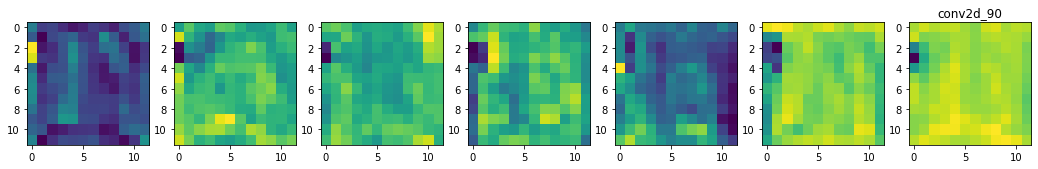

In [90]:
name = layer_names[4]
ind = [i for i in range(0, layer_90_activation.shape[-1], 21)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(layer_90_activation[0,:,:,i])
    j += 1
plt.title(name)

In [91]:
layer_109_activation = activations[5]
layer_109_activation.shape

(1, 12, 12, 192)

Text(0.5, 1.0, 'conv2d_109')

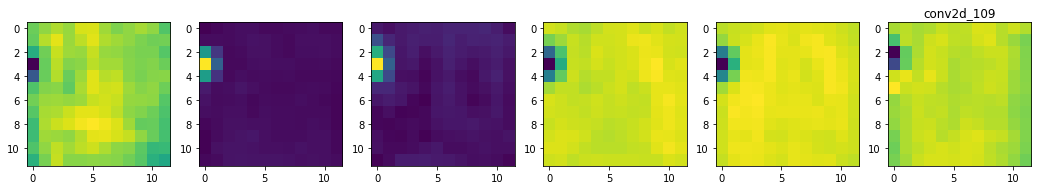

In [92]:
name = layer_names[5]
ind = [i for i in range(0, layer_109_activation.shape[-1], 32)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(layer_109_activation[0,:,:,i])
    j += 1
plt.title(name)

In [93]:
layer_134_activation = activations[6]
layer_134_activation.shape

(1, 12, 12, 128)

Text(0.5, 1.0, 'conv2d_134')

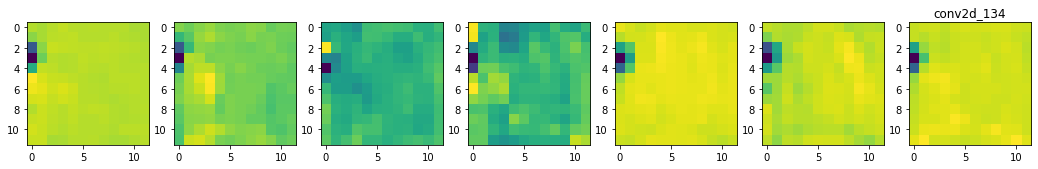

In [94]:
name = layer_names[6]
ind = [i for i in range(0, layer_134_activation.shape[-1], 21)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(layer_134_activation[0,:,:,i])
    j += 1
plt.title(name)

In [95]:
layer_153_activation = activations[7]
layer_153_activation.shape

(1, 12, 12, 192)

Text(0.5, 1.0, 'conv2d_153')

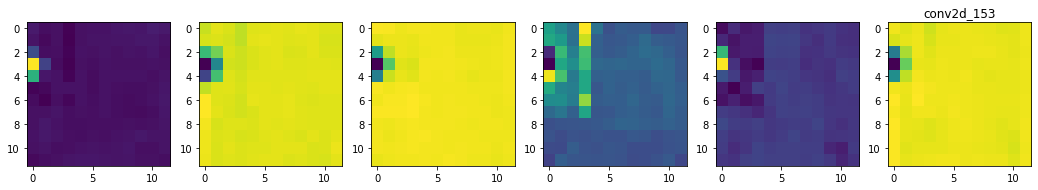

In [96]:
name = layer_names[7]
ind = [i for i in range(0, layer_153_activation.shape[-1], 32)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(layer_153_activation[0,:,:,i])
    j += 1
plt.title(name)

In [97]:
layer_178_activation = activations[8]
layer_178_activation.shape

(1, 5, 5, 224)

Text(0.5, 1.0, 'conv2d_178')

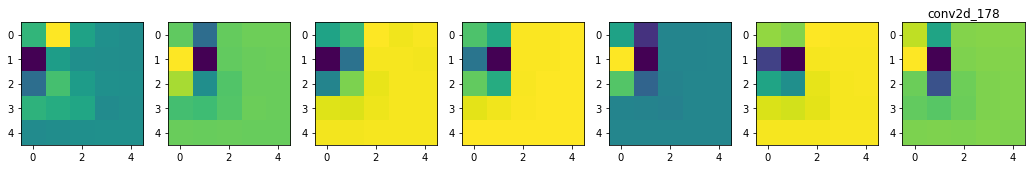

In [98]:
name = layer_names[8]
ind = [i for i in range(0, layer_178_activation.shape[-1], 37)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(layer_178_activation[0,:,:,i])
    j += 1
plt.title(name)

In [99]:
layer_199_activation = activations[9]
layer_199_activation.shape

(1, 5, 5, 256)

Text(0.5, 1.0, 'conv2d_199')

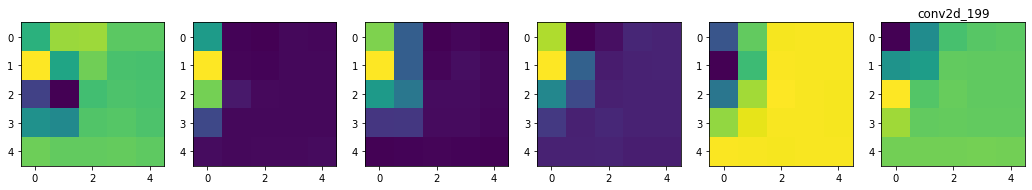

In [100]:
name = layer_names[9]
ind = [i for i in range(0, layer_199_activation.shape[-1], 43)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(layer_199_activation[0,:,:,i])
    j += 1
plt.title(name)

In [101]:
final_layer_activation = activations[10]
final_layer_activation.shape

(1, 5, 5, 1536)

Text(0.5, 1.0, 'conv_7b')

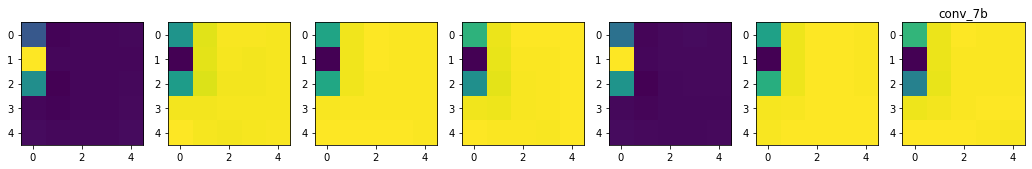

In [103]:
name = layer_names[10]
ind = [i for i in range(0, final_layer_activation.shape[-1], 255)]
fig, axis = plt.subplots(1,len(ind), figsize=(18,6))
j = 0
for i in ind:
    axis[j].imshow(final_layer_activation[0,:,:,i])
    j += 1
plt.title(name)